This notebook will be collected automatically at **6pm on Monday** from `/home/data_scientist/assignments/Week3` directory on the course JupyterHub server. If you work on this assignment on the course Jupyterhub server, just make sure that you save your work and instructors will pull your notebooks automatically after the deadline. If you work on this assignment locally, the only way to submit assignments is via Jupyterhub, and you have to place the notebook file in the correct directory with the correct file name before the deadline.

1. Make sure everything runs as expected. First, restart the kernel (in the menubar, select `Kernel` → `Restart`) and then run all cells (in the menubar, select `Cell` → `Run All`).
2. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed by the autograder.
3. Do not change the file path or the file name of this notebook.
4. Make sure that you save your work (in the menubar, select `File` → `Save and CheckPoint`)

# Problem 3.2. Supervised Learning: Support Vector Machine

In this problem, we will use Support Vector Machine to see if we can use machine learning techniques to predict departure delays at the O'Hare airport (ORD).

In [1]:
% matplotlib inline

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import svm, preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score

from nose.tools import assert_equal, assert_in, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal
from pandas.util.testing import assert_frame_equal, assert_index_equal

sns.set(style="white")

/opt/conda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/conda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


We use the 2001 on-time airline performance data set. We import the following columns:

- Column 5: CRSDepTime, scheduled departure time (local, hhmm)
- Column 8: UniqueCarrier, unique carrier code
- Column 15: DepDelay, departure delay, in minutes
- Column 16: Origin, origin IATA airport code
- Column 18: Distance, in miles

In [2]:
df = pd.read_csv(
    '/home/data_scientist/data/2001.csv',
    encoding='latin-1',
    usecols=(5, 8, 15, 16, 18)
    )

In this problem, we use only `AA` flights (American Airlines, the largest airline using the O'Hare airport). Recall that we had an unbalanced data set by using `DepDelay > 15` in Problem 3.1. In this problem, we use `DepDelay > 0` to make our data set more balanced.

In [3]:
local = df[(df['Origin'] == 'ORD') & (df['UniqueCarrier'] == 'AA')]
local = local.drop(['UniqueCarrier', 'Origin'], axis=1) # we don't need the Month and Origin columns anymore.
local['Delayed'] = (local['DepDelay'] > 0).astype(np.int) # 1 if a flight was delayed, 0 if not.
local = local.drop('DepDelay', axis=1).dropna() # we don't need the DepDelay column.

Let's compare the number of delayed flights to non-delayed flights and check if we have a balanced data set.

```python
>>> print('Delayed: {}\nNot delayed: {}'.format(
    (local.Delayed == 0).sum(),
    (local.Delayed == 1).sum()
    ))
```

```
Delayed: 61932
Not delayed: 44006
```

In [4]:
print('Delayed: {}\nNot delayed: {}'.format(
    (local.Delayed == 0).sum(),
    (local.Delayed == 1).sum()
    ))

Delayed: 61932
Not delayed: 44006


Let's print the first few columns and see what we'll be working with.

```python
>>> print(local.head(5))
```

```
        CRSDepTime  Distance  Delayed
398444        1905      1846        1
398445        1905      1846        1
398446        1905      1846        1
398447        1905      1846        0
398448        1905      1846        1
```

In [5]:
print(local.head(5))

        CRSDepTime  Distance  Delayed
398444        1905      1846        1
398445        1905      1846        1
398446        1905      1846        1
398447        1905      1846        0
398448        1905      1846        1


## Split

Write a function named `split()` that takes a DataFrame as its first argument. The second argument `test_column` specifies which column should be used as a label (`Delayed` in our case). All remaining columns except `test_column` should be used for training. In other words, the returned DataFrames `y_train` and `y_test` both have only one column, `test_column`, and `X_train` and `X_test` contain all columns in `df` minus `test_column`.

This function is (almost) the same function we wrote in Problem 3.1. You could simply cut and paste the answer. But cut-and-pasting is boring (and it's easier to work with Numpy arrays in this problem), so let's modify the function a little bit and **return Numpy arrays** this time. Pay close attention to the shape of `y_train` and `y_test` arrays: they should be **row vectors**, not column vectors.

```python
>>> print(local[['Delayed']].values[:5]) # column vector
```

```
[[0]
 [0]
 [0]
 [1]
 [0]]
```

```python
>>> print(local[['Delayed']].values.shape) # column vector
```

```
(341284, 1)
```

```python
>>> print(local_delayed_as_a_row_vector[:5])
```

```
[0 0 0 1 0]
```

```python
>>> print(local_deayed_as_a_row_vector.shape)
(341284,)
```

Don't forget that we have to pass an instance of `check_random_state()` to the `train_test_split()` function for reproducibility.

In [6]:
def split(df, test_column, test_size, random_state):
    '''
    Uses sklearn.train_test_split to split "df" into a testing set and a test set.
    The "test_columns" lists the column that we are trying to predict.
    All columns in "df" except "test_columns" will be used for training.
    The "test_size" should be between 0.0 and 1.0 and represents the proportion of the
    dataset to include in the test split.
    The "random_state" parameter is used in sklearn.train_test_split.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    test_columns: A list of strings
    test_size: A float
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    A 4-tuple of numpy.ndarrays
    '''
    ##################
    X = df.drop(test_column, axis=1).values
    y = df[test_column].values.transpose()[0]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)
    ##################
    
    return X_train, X_test, y_train, y_test

Now we will split `local` into a training set and a test set. We won't use a validation set this time, because training SVM is more computationally expensive than training a $k$-Nearest Neighbors. However, keep in mind that SVM also has hyperparameters that need to be tuned, e.g., `kernel`, `C`, or `gamma` values. In practice, you should create a validation set, or preferably perform a cross-validation.

In [7]:
X_train, X_test, y_train, y_test = split(
    df=local,
    test_column=['Delayed'],
    test_size=0.4,
    random_state=check_random_state(0)
    )

Tests.

In [8]:
n_samples_train, n_features_train = X_train.shape
n_samples_test, n_features_test = X_test.shape

assert_equal(n_features_train, 2)
assert_equal(n_features_test, 2)
n_features = n_features_train

assert_equal(np.abs(n_samples_train - np.round(len(local) * 0.6)) <= 1, True)
assert_equal(np.abs(n_samples_test - np.round(len(local) * 0.4)) <= 1, True)

assert_array_equal(X_train[:5],
    np.array(
        [[ 1500.,  1846.],
         [ 1415.,   802.],
         [ 1138.,   409.],
         [ 1649.,   723.],
         [ 1835.,   678.]]
        ))
assert_array_equal(X_test[:5],
    np.array(
        [[  645.,  1745.],
         [  620.,   622.],
         [  645.,  1745.],
         [ 2040.,   678.],
         [  835.,   268.]]
        ))

assert_array_equal(y_train[:10], np.array([1, 0, 1, 0, 1, 1, 1, 1, 0, 1]))
assert_array_equal(y_test[:10], np.array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1]))

## Scale

In Problem 3.1, we saw that the columns we want to use for training have different scales, so we scaled each column to the [0, 1] range. For SVM, we will scale features to be in [-1, -1] range.

In [9]:
def standardize(x):
    '''
    Takes a 2d array and normlizes each feature (each column) to be in range [-1, 1].
    
    Parameters
    ----------
    array: A numpy.ndarray
    
    Returns
    -------
    A numpy.ndarray
    '''
    ##################
    x_min = x.min(axis=0)[np.newaxis,:]
    x_max = x.max(axis=0)[np.newaxis,:]
    
    scaled = (x - x_min)/(x_max-x_min)*2-1
    ##################
    return scaled

In [10]:
array_t = np.array(
    [[-4,  3,  0, -5, -3],
     [-2, -3,  1,  3, -1],
     [-3,  1,  3,  1,  0]]
    )

scaled_t = standardize(array_t)
assert_array_almost_equal(scaled_t, np.array(
    [[-1., 1. , -1., -1., -1.],
     [ 1., -1., -0.33333333, 1., 0.33333333],
     [ 0., 0.33333333, 1., 0.5, 1.]]
    ))

In [11]:
X_train_scaled, X_test_scaled = map(standardize, [X_train, X_test])

## Train SVM

Now that we have standardized the training set, we are ready to apply the SVM algorithm.

Write a function named `fit_and_predict()`. It should return a tuple of `(svm.SVC, np.ndarray)`.

In [12]:
def fit_and_predict(X_train, y_train, X_test, kernel):
    '''
    Fits a Support Vector Machine on the training data on "X_train" and "y_train".
    Returns the predicted values on "X_test".
    
    Parameters
    ----------
    X_train: A numpy.ndarray
    y_train: A numpy.ndarray
    X_test: A numpy.ndarray
    kernel: A string that specifies kernel to be used in SVM
    
    Returns
    -------
    model: An svm.SVC instance trained on "X_train" and "y_train"
    y_pred: A numpy array. Values predicted by "model" on "X_test"
    '''
    ##################
    model = svm.SVC(kernel=kernel)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    ##################

    return model, y_pred

Training SVM on `X_train` and `y_train` will take a while, so let's first make sure that the function works correctly.

In [13]:
# toy sample
X_train_t = [[-2, -1], [-1, -1], [-1, -2], [1, 1], [1, 2], [2, 1]]
y_train_t = [1, 1, 1, 2, 2, 2]
X_test_t = [[-1, -1], [2, 2], [3, 2]]
y_test_t = [1, 2, 2]

model1, pred1 = fit_and_predict(X_train_t, y_train_t, X_test_t, 'linear')
assert_equal(isinstance(model1, svm.SVC), True)
assert_equal(model1.kernel, 'linear')
assert_array_equal(pred1, y_test_t)

model2, pred2 = fit_and_predict(X_train_t, y_train_t, X_test_t, 'rbf')
assert_equal(model2.kernel, 'rbf')
assert_array_equal(pred2, y_test_t)

Run the following cell to actually train on the flights data. It might take a while.

In [14]:
clf, y_pred = fit_and_predict(X_train_scaled, y_train, X_test_scaled, 'rbf')

Let's see what the accuracy score is.

In [15]:
print(accuracy_score(y_test, y_pred))

0.593779497829


It looks like using only two features `CRSDepTime` and `Distance` really hurt our performance (and predicting flight delays is a hard problem). To improve performance, we probably need to include more features, and not just the features provided in `2001.csv`, but data from other sources. For example, I would guess that weather has a significant impact on flights delays. One possibility is to find historical weather data (which will likely require using techniques you learned in the previous course) and include weather as a feature.

## Confusion matrix

Plot a a colored heatmap that displays the relationship between predicted and actual types. The `plot_confusion()` function must return a `maplotlib.axes.Axes` object. Use `numpy.histogram2d()` and `seaborn.heatmap()` as demonstrated in lesson 1. Here's an exmaple:

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week3/assignments/images/svm_confusion.png)

In [22]:
def plot_confusion():
    '''
    Plots a confusion matrix using numpy.histogram2d() and seaborn.heatmap().
    Returns a maptlotlib.axes.Axes instance.
    '''
    ##################
    x = y_test
    y = y_pred
    
    hist = np.histogram2d(x, y, bins=2)[0]
    ax = sns.heatmap(hist, annot=True, fmt = '.0f')
    
    ax.set_xticklabels(['Not delayed', 'Delayed'])
    ax.set_yticklabels(['Delayed', 'Not delayed'])
    ax.title.set_text('Confusion Matrix for SVM')
    ##################

    return ax

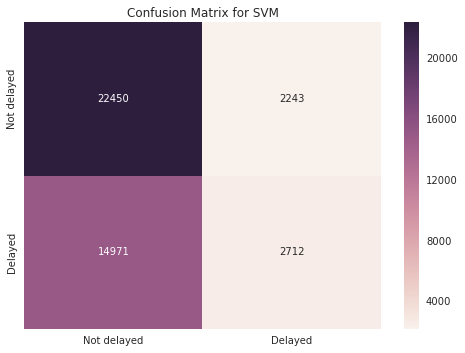

In [23]:
ax = plot_confusion()

In [24]:
assert_equal(isinstance(ax, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

texts = [t.get_text() for t in ax.texts]
assert_equal(texts, ['14971', '2712', '22450', '2243'])
             
x_tick_labels = [l.get_text() for l in ax.get_xticklabels()]
y_tick_labels = [l.get_text() for l in ax.get_yticklabels()]
assert_equal(y_tick_labels, ['Delayed', 'Not delayed'])

assert_is_not(len(ax.title.get_text()), 0, msg="Your plot doesn't have a title.")